# NNs-Based 1D Acoustic Wave Simulation with a Source Term

This notebook presents a neural network aproximation to the solution for the 1D elastic wave equation

\begin{equation}
\rho(x) \partial_t^2 u(x,t) = \partial_x (\mu(x) \partial_x u(x,t)) + f(x,t),
\end{equation}


In the following code block, we import the necessary libraries for our notebook. This includes NumPy for numerical operations, PyTorch for building and training the neural network, Matplotlib for plotting, a utility module for additional plotting functions, and the time module for timing our training process.

In [1]:
# Import libraries for numerical operations
import numpy as np

# Import PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim

# Import libraries for data visualization
import matplotlib.pyplot as plt
from utils_plots import *  # utility module for additional plotting functions

# Import libraries for random operations and data serialization
import random
import pickle

# Import libraries for utility functions
import time  # to time our training process
from scipy.interpolate import griddata  # for data interpolation

# Configure warnings
import warnings
warnings.filterwarnings("ignore")  # Ignore warning messages

In the following code block, we load the data obteined from a spectral elements implemented in the notebook W9_se_homo_1d_solution.ipynb with modified input parameters of the course [computers, waves, simulations](https://www.coursera.org/learn/computers-waves-simulations).

In [2]:
# Open the file containing the data
with open('data/4_se_data.pkl', 'rb') as f:
    # Load the data from the file
    # t_grid, x_grid, and u_grid are expected to be in the file
    t_grid, x_grid, u_grid = pickle.load(f)

# Convert the loaded data to NumPy arrays for easier manipulation
# This step is necessary if the loaded data is not already in NumPy array format
x_grid = np.array(x_grid)  # Grid of x values
t_grid = np.array(t_grid)  # Grid of t (time) values
u_grid = np.array(u_grid)  # Grid of u (wave amplitude) values

This cell creates a new grid of points and performs interpolation on the u_grid data using the 'nearest' method. It then identifies and replaces any NaN values in the interpolated data with the nearest non-NaN values.

In [3]:
# Define the number of points for the new grid
num_points = 100

# Create a new grid of points
# The range of the grid is determined by the minimum and maximum values of the original grids
x_new = np.linspace(np.nanmin(x_grid), np.nanmax(x_grid), num_points)
t_new = np.linspace(np.nanmin(t_grid), np.nanmax(t_grid), num_points)

# Create a meshgrid using the new x and t values
x_grid_new, t_grid_new = np.meshgrid(x_new, t_new)

# Prepare the data for interpolation
# The original x and t grids are flattened and stacked vertically
# The u_grid is also flattened to match the shape
points = np.vstack((x_grid.flatten(), t_grid.flatten())).T
values = u_grid.flatten()

# Perform the interpolation using the 'nearest' method
u_grid_new = griddata(points, values, (x_grid_new, t_grid_new), method='nearest')

# Identify the NaN values in the interpolated data
mask = np.isnan(u_grid_new)

# Replace the NaN values with the nearest non-NaN values
u_grid_new[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), u_grid_new[~mask])

# Update the original grids with the new grids
x_grid = x_grid_new
t_grid = t_grid_new
u_grid = u_grid_new

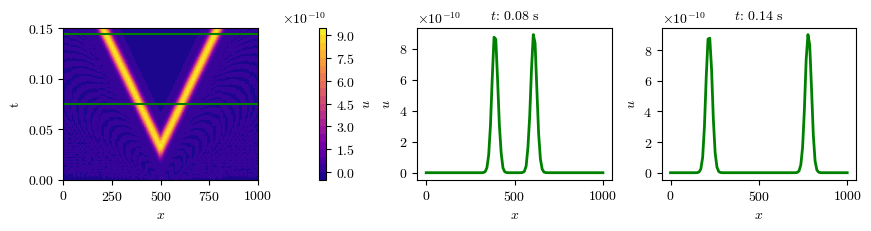

In [4]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(8.6, 2.2))

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z):
    contourf_plot = ax.contourf(x, y, z, origin='lower', extent=(0, 1, 0, 1), levels=20, cmap='plasma')
    ax.set_xlabel('$x$')
    ax.set_ylabel('t')
    ax.axhline(y=np.max(y)/2, color='green')
    ax.axhline(y=y[-5,0], color='green')
    fig.colorbar(contourf_plot, ax=ax, label='$u$')


# Define a function to plot a line graph
def plot_line(ax, x, y, t):
    ax.plot(x, y, color='green', linewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u$')
    ax.set_title("$t$: {:.2f} s".format(t), fontsize=10)

# Plot the contour graph
plot_contour(axs[0], x_grid, t_grid, u_grid)

# Plot the line graphs
plot_line(axs[1], x_grid[int(x_grid.shape[0]/2),:], u_grid[int(x_grid.shape[0]/2),:], t_grid[int(x_grid.shape[0]/2),0])
plot_line(axs[2], x_grid[int(x_grid.shape[0]-2),:], u_grid[int(x_grid.shape[0]-5),:], t_grid[int(x_grid.shape[0]-5),0])

# Display the plot
plt.show()

This cell converts the numpy arrays to PyTorch tensors, normalizes these tensors, and then converts them back to numpy arrays for visualization.

In [5]:
# Convert the numpy arrays to PyTorch tensors
# The 'unsqueeze' function is used to add an extra dimension to the tensors
x_grid_tensor = torch.from_numpy(x_grid).float().unsqueeze(-1)
t_grid_tensor = torch.from_numpy(t_grid).float().unsqueeze(-1)
u_grid_tensor = torch.from_numpy(u_grid).float().unsqueeze(-1)

# Normalize the tensors
# This is done by subtracting the minimum value and dividing by the range (max - min)
x_grid_tensor_normalized = (x_grid_tensor - x_grid_tensor.min()) / (x_grid_tensor.max() - x_grid_tensor.min())
t_grid_tensor_normalized = (t_grid_tensor - t_grid_tensor.min()) / (t_grid_tensor.max() - t_grid_tensor.min())
u_grid_tensor_normalized = (u_grid_tensor - u_grid_tensor.min()) / (u_grid_tensor.max() - u_grid_tensor.min())

# Convert the normalized tensors back to numpy arrays for visualization
# The 'detach' function is used to remove the tensors from the computation graph
# The 'reshape' function is used to restore the original shape of the arrays
u_grid_normalized = u_grid_tensor_normalized.detach().numpy().reshape(x_grid.shape)
x_grid_normalized = x_grid_tensor_normalized.detach().numpy().reshape(x_grid.shape)
t_grid_normalized = t_grid_tensor_normalized.detach().numpy().reshape(x_grid.shape)

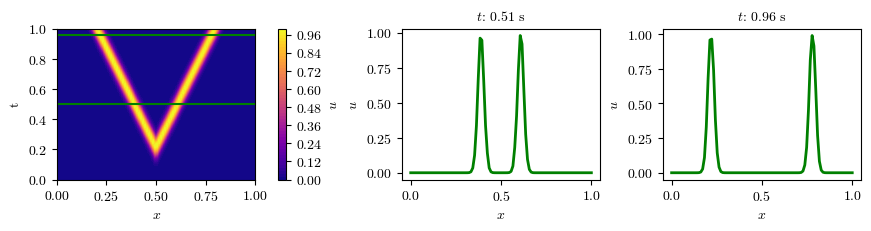

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(8.6, 2.2))

# First subplot
contourf_plot=axs[0].contourf(x_grid_normalized, t_grid_normalized, u_grid_normalized, origin='lower', extent=(0, 1, 0, 1), levels=50,cmap='plasma')
#axs[0].contour(x_grid_tensor_normalized, t_grid_tensor_normalized, u_grid_normalized, levels=50, colors='white', alpha=0.2, linestyles='solid')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('t')
axs[0].axhline(np.max(t_grid_normalized)/2, color='green')
axs[0].axhline(t_grid_normalized[-5,0], color='green')
fig.colorbar(contourf_plot, ax=axs[0], label='$u$')

# Second subplot
axs[1].plot(x_grid_normalized[int(x_grid.shape[0]/2),:], u_grid_normalized[int(x_grid.shape[0]/2),:], color='green', linewidth=2)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$u$')
axs[1].set_title("$t$: {:.2f} s".format(t_grid_normalized[int(x_grid.shape[0]/2),0]),fontsize=10)

# Third subplot
axs[2].plot(x_grid_normalized[x_grid.shape[0]-5,:], u_grid_normalized[x_grid.shape[0]-5,:], color='green', linewidth=2)
axs[2].set_xlabel('$x$')
axs[2].set_ylabel('$u$')
axs[2].set_title("$t$: {:.2f} s".format(t_grid_normalized[x_grid.shape[0]-5,0]),fontsize=10)

fig.savefig('imgs/4_Normalized_Original_Data.png', format='png')

plt.show()

This cell defines a neural network with three fully connected layers, creates an instance of this network, and sets up the Adam optimizer and Mean Squared Error loss function for training the network.

In [7]:
# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(2, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 20)
        self.output_layer = nn.Linear(20, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        x = self.output_layer(x)
        return x

# Create an instance of the neural network
neural_net = NeuralNetwork()

# Define the learning rate
learning_rate = 0.01

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(neural_net.parameters(), lr=learning_rate)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

This cell concatenates normalized tensors to form the input data, selects random indices from the input data for training, and selects the corresponding indices from the output data. It then prints the shape of the input data.

In [8]:
# Concatenate x and t tensors to form the input data
input_data = torch.cat((x_grid_tensor_normalized, t_grid_tensor_normalized), dim=-1)

# Define the output data
output_data = u_grid_tensor_normalized

# Define the number of random indices to select
num_indices = int(input_data.shape[0]/1)

# Select random indices from the first dimension of input_data
indices_1 = random.sample(range(input_data.shape[0]), num_indices)

# Select random indices from the second dimension of input_data
indices_2 = random.sample(range(input_data.shape[1]), num_indices)

# Use only the selected indices for training
selected_data = input_data[indices_1, :][:, indices_2]

# Select the same indices from output_data
output_data = output_data[indices_1, :][:, indices_2]

# Print the shape of the input data
print(output_data.shape)

torch.Size([100, 100, 1])


This code block trains a neural network for a specified number of iterations, recording the loss at each step. It also calculates and prints the training time. The training process summary, including details about the neural network architecture, optimizer used, learning rate, number of iterations, initial and final loss, training time, average loss, and the iteration with the minimum loss, is saved to a text file.

In [9]:
# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Define the number of training iterations
num_iterations = 20_001

# Train the neural network
for i in range(num_iterations):
    # Make a prediction based on the input data
    prediction = neural_net(selected_data)
    
    # Calculate the loss
    loss = loss_func(prediction, output_data)
    
    # Append the current loss value to the list
    loss_values.append(loss.item())
    
    # Print the loss every 1000 iterations
    if i % 1000 == 0:
        print(f"Iteration {i}: Loss {loss.item()}")
    
    # Clear gradients for the next training iteration
    optimizer.zero_grad()
    
    # Perform backpropagation and compute gradients
    loss.backward()
    
    # Update the weights
    optimizer.step()

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Define the summary file path
summary_file_path = "summaries/4_1D_Wave_Source_NNs.txt"

# Save a summary of the training process to a text file
with open(summary_file_path, "w") as file:
    file.write("Summary of Neural Network Training\n")
    file.write("=================================\n\n")
    file.write(f"Neural Network Architecture:\n{neural_net}\n\n")
    file.write(f"Optimizer Used:\n{type(optimizer).__name__}\n\n")
    file.write(f"Learning Rate:\n{optimizer.param_groups[0]['lr']}\n\n")
    file.write(f"Number of Iterations:\n{len(loss_values)}\n\n")
    file.write(f"Initial Loss:\n{loss_values[0]}\n\n")
    file.write(f"Final Loss:\n{loss_values[-1]}\n\n")
    file.write(f"Training Time:\n{elapsed_time} seconds\n\n")
    
    # Calculate the average loss
    average_loss = sum(loss_values) / len(loss_values)
    file.write(f"Average Loss:\n{average_loss}\n\n")
    
    # Find the iteration with the minimum loss
    min_loss_value = min(loss_values)
    min_loss_iteration = loss_values.index(min_loss_value)
    file.write(f"Minimum Loss:\n{min_loss_value} at iteration {min_loss_iteration}\n\n")

Iteration 0: Loss 0.08780530095100403
Iteration 1000: Loss 0.0002048788737738505
Iteration 2000: Loss 6.195251626195386e-05
Iteration 3000: Loss 4.615154102793895e-05
Iteration 4000: Loss 0.0005614769761450589
Iteration 5000: Loss 3.0865547159919515e-05
Iteration 6000: Loss 2.597061393316835e-05
Iteration 7000: Loss 2.4151566321961582e-05
Iteration 8000: Loss 2.211303944932297e-05
Iteration 9000: Loss 0.0001553206384414807
Iteration 10000: Loss 2.0982110072509386e-05
Iteration 11000: Loss 2.5726601961650886e-05
Iteration 12000: Loss 2.7061396394856274e-05
Iteration 13000: Loss 4.4679622078547254e-05
Iteration 14000: Loss 1.7811136785894632e-05
Iteration 15000: Loss 1.6760206563048996e-05
Iteration 16000: Loss 1.7706710423226468e-05
Iteration 17000: Loss 1.6571815649513155e-05
Iteration 18000: Loss 1.9220533431507647e-05
Iteration 19000: Loss 1.5289462680811994e-05
Iteration 20000: Loss 1.4454787560680415e-05
Training time: 91.63862180709839 seconds


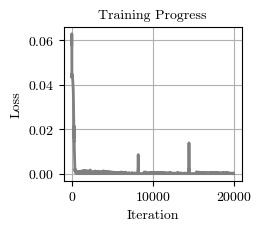

In [10]:
# Create a figure for the plot
fig = plt.figure(figsize=(2.5, 2.2))

# Plot the loss values recorded during training
plt.plot(loss_values, color='gray', linewidth=2)

# Set the labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Set the title for the plot
plt.title('Training Progress', fontsize=10)

# Display the grid
plt.grid(True)

# Save the plot as a PDF file in the 'imgs' directory
fig.savefig('imgs/4_1_Training_Progress.png', format='png')

# Display the plot
plt.show()

In [11]:
# Save the trained model's parameters to a file
torch.save(neural_net.state_dict(), 'models/4_1D_Wave_Source_NNs.pth')

# Initialize a new instance of the neural network
neural_net = NeuralNetwork()

# Load the saved parameters into the new instance of the neural network
neural_net.load_state_dict(torch.load('models/4_1D_Wave_Source_NNs.pth'))

# Ensure the new neural network is in evaluation mode
neural_net.eval()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

This cell concatenates normalized x and t grid tensors to form the input data, uses a neural network to generate predictions, and then plots the original, predicted, and difference values of u in a contour graph.

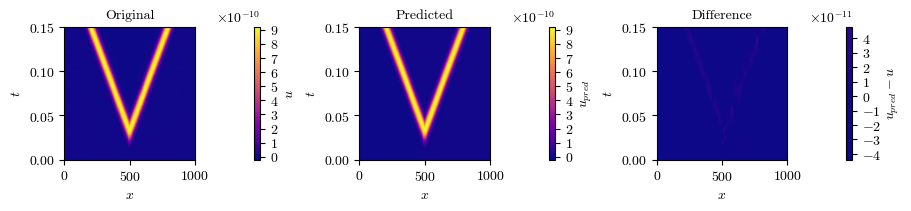

In [13]:
# Concatenation of x and y to form the input data
input_data = torch.cat((x_grid_tensor_normalized, t_grid_tensor_normalized), dim=-1)

# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net(input_data).detach().numpy().reshape(x_grid_normalized.shape)

# Rescale u_pred
u_pred = u_pred * (np.max(u_grid) - np.min(u_grid)) + np.min(u_grid)

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower', levels=50, cmap='plasma', vmax=np.max(u_grid), vmin=np.min(u_grid))
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$') 
    fig.colorbar(im, ax=ax, label=label)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Plot the original u values
plot_contour(axs[0], x_grid, t_grid, u_grid, 'Original', '$u$')

# Plot the predicted u values
plot_contour(axs[1], x_grid, t_grid, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], x_grid, t_grid, u_pred-u_grid, 'Difference', '$u_{pred}-u$')

# Uncomment the following line to save the plot as a PNG file in the 'imgs' directory
fig.savefig('imgs/4_1_Predicted_and_Difference_1D_Wave_Source_NNs.png', format='png')

# Display the plot
plt.show()

This cell creates a figure with three subplots, defines functions for plotting a contour graph and line graphs, applies these functions to plot the contour graph and line graphs using normalized grid and prediction data, and finally displays the plot.

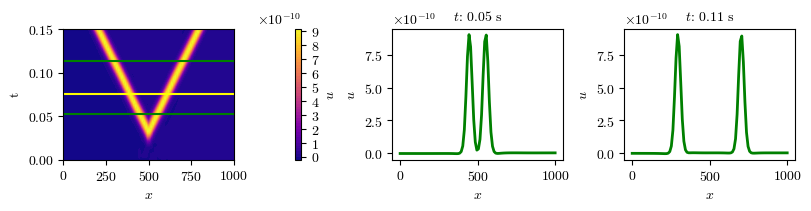

In [14]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(8.0, 2.0))

# Define the fractions for the horizontal lines and line graphs
fractions = [0.35, 0.75]

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, fractions):
    contourf_plot = ax.contourf(x, y, z, origin='lower', extent=(0, 1, 0, 1), levels=50, cmap='plasma')
    ax.set_xlabel('$x$')
    ax.set_ylabel('t')
    fig.colorbar(contourf_plot, ax=ax, label='$u$')
    # Draw a horizontal line at t=np.max(t_grid)/2
    ax.axhline(y=np.max(t_grid)*0.5, color='yellow')
    for fraction in fractions:
        ax.axhline(np.max(y)*fraction, color='green')

# Define a function to plot a line graph
def plot_line(ax, x, y, t):
    ax.plot(x, y, color='green', linewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u$')
    ax.set_title("$t$: {:.2f} s".format(t), fontsize=10)

# Plot the contour graph
plot_contour(axs[0], x_grid, t_grid, u_pred, fractions)

# Plot the line graphs
for i, fraction in enumerate(fractions, start=1):
    plot_line(axs[i], x_grid[int(x_grid.shape[0]*fraction),:], u_pred[int(x_grid.shape[0]*fraction),:], t_grid[int(x_grid.shape[0]*fraction),0])

fig.savefig('imgs/4_1_1D_Wave_Source_NNs.png', format='png')
# Display the plot
plt.show()

This cell creates the input data by concatenating normalized `x` and `t` grid tensors, defines the output data, and selects a subset for training. The subset consists of the first third of the `t` coordinate and the entire `x` coordinate, chosen using random indices.

In [15]:
# Concatenate x and t tensors to form the input data
input_data = torch.cat((x_grid_tensor_normalized, t_grid_tensor_normalized), dim=-1)

# Define the output data
output_data = u_grid_tensor_normalized

# Use only a fraction of the input data as the selected indices for training
selected_data = input_data[:int(input_data.shape[0]/3), :][:int(input_data.shape[1]), :]

# Use only a fraction of the output data as the selected indices for training
output_data = output_data[:int(input_data.shape[0]/3), :][:int(input_data.shape[1]), :]

# Define the number of random indices to select
num_indices_1 = int(selected_data.shape[0]/1)
num_indices_2 = int(selected_data.shape[1]/1)


# Select random indices from the first dimension of input_data
indices_1 = random.sample(range(selected_data.shape[0]), num_indices_1)

# Select random indices from the second dimension of input_data
indices_2 = random.sample(range(selected_data.shape[1]), num_indices_2)

# Use only the selected indices for training
selected_data = selected_data[indices_1, :][:, indices_2]

# Select the same indices from output_data
output_data = output_data[indices_1, :][:, indices_2]

# Print the shape of the input data
print(output_data.shape)

torch.Size([33, 100, 1])


This cell defines a new neural network class with three fully connected layers, creates an instance of this network, and sets up the learning rate, optimizer (Adam), and loss function (Mean Squared Error) for training the network.

In [16]:
# Define a new neural network class with three fully connected layers
class NeuralNetwork_2(nn.Module):
    def __init__(self):
        super(NeuralNetwork_2, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(2, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 20)
        self.output_layer = nn.Linear(20, 1)

    def forward(self, x):
        # Define the forward pass
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        x = self.output_layer(x)
        return x

# Create an instance of the new neural network
neural_net_2 = NeuralNetwork_2()

# Define the learning rate
learning_rate = 0.01

# Define an optimizer (Adam) for training the new network
optimizer = optim.Adam(neural_net_2.parameters(), lr=learning_rate)

# Define a loss function (Mean Squared Error) for training the new network
loss_func = nn.MSELoss()

This cell trains the **NEW** neural network, tracks the loss over iterations, calculates the training time, and writes a summary of the training process to a text file.

In [17]:
# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Define the number of training iterations
num_iterations = 20_001

# Train the neural network
for i in range(num_iterations):
    # Make a prediction based on the input data
    prediction = neural_net_2(selected_data)
    
    # Calculate the loss
    loss = loss_func(prediction, output_data)
    
    # Append the current loss value to the list
    loss_values.append(loss.item())
    
    # Print the loss every 1000 iterations
    if i % 1000 == 0:
        print(f"Iteration {i}: Loss {loss.item()}")
    
    # Clear gradients for the next training iteration
    optimizer.zero_grad()
    
    # Perform backpropagation and compute gradients
    loss.backward()
    
    # Update the weights
    optimizer.step()

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Define the summary file path
summary_file_path = "summaries/4_2_1D_Wave_Source_NNs.txt"

# Save a summary of the training process to a text file
with open(summary_file_path, "w") as file:
    file.write("Summary of Neural Network Training\n")
    file.write("=================================\n\n")
    file.write(f"Neural Network Architecture:\n{neural_net}\n\n")
    file.write(f"Optimizer Used:\n{type(optimizer).__name__}\n\n")
    file.write(f"Learning Rate:\n{optimizer.param_groups[0]['lr']}\n\n")
    file.write(f"Number of Iterations:\n{len(loss_values)}\n\n")
    file.write(f"Initial Loss:\n{loss_values[0]}\n\n")
    file.write(f"Final Loss:\n{loss_values[-1]}\n\n")
    file.write(f"Training Time:\n{elapsed_time} seconds\n\n")
    
    # Calculate the average loss
    average_loss = sum(loss_values) / len(loss_values)
    file.write(f"Average Loss:\n{average_loss}\n\n")
    
    # Find the iteration with the minimum loss
    min_loss_value = min(loss_values)
    min_loss_iteration = loss_values.index(min_loss_value)
    file.write(f"Minimum Loss:\n{min_loss_value} at iteration {min_loss_iteration}\n\n")

Iteration 0: Loss 0.026047661900520325
Iteration 1000: Loss 0.00022983536473475397
Iteration 2000: Loss 2.9775834264000878e-05
Iteration 3000: Loss 1.484407766838558e-05
Iteration 4000: Loss 1.0374142220825888e-05
Iteration 5000: Loss 7.590890618303092e-06
Iteration 6000: Loss 8.55293546919711e-06
Iteration 7000: Loss 7.501790969399735e-05
Iteration 8000: Loss 6.1785422076354735e-06
Iteration 9000: Loss 4.017553692392539e-06
Iteration 10000: Loss 0.0002637672587297857
Iteration 11000: Loss 2.6825023269339e-06
Iteration 12000: Loss 4.4504882680485025e-05
Iteration 13000: Loss 3.8692498492309824e-05
Iteration 14000: Loss 4.261771755409427e-05
Iteration 15000: Loss 8.782189070188906e-06
Iteration 16000: Loss 2.694030399652547e-06
Iteration 17000: Loss 1.303790327256138e-06
Iteration 18000: Loss 1.0679716524464311e-06
Iteration 19000: Loss 9.643929388403194e-07
Iteration 20000: Loss 8.393203643208835e-07
Training time: 45.94084596633911 seconds


This cell saves the trained model's parameters to a file, initializes a new instance of the neural network, loads the saved parameters into this new instance, and sets the network to evaluation mode.

In [18]:
# Save the trained model's parameters to a file
torch.save(neural_net_2.state_dict(), 'models/4_2_1D_Wave_Source_NNs.pth')

# Initialize a new instance of the neural network
neural_net_2 = NeuralNetwork_2()

# Load the saved parameters into the new instance of the neural network
neural_net_2.load_state_dict(torch.load('models/4_2_1D_Wave_Source_NNs.pth'))

# Ensure the new neural network is in evaluation mode
neural_net_2.eval()

NeuralNetwork_2(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

This cell concatenates normalized x and t grid tensors to form the input data, generates predictions using the trained neural network, rescales the predictions, and then plots the original, predicted, and difference between predicted and original values in a contour graph.

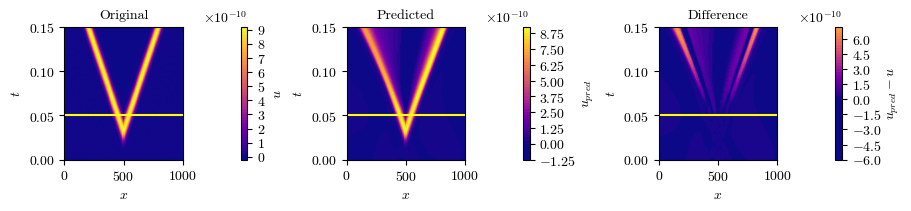

In [20]:
# Concatenation of x and y to form the input data
input_data = torch.cat((x_grid_tensor_normalized, t_grid_tensor_normalized), dim=-1)

# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net_2(input_data).detach().numpy().reshape(x_grid_normalized.shape)

# Rescale u_pred
u_pred = u_pred * (np.max(u_grid) - np.min(u_grid)) + np.min(u_grid)

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower', levels=50, cmap='plasma', vmax=np.max(u_grid), vmin=np.min(u_grid))
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    fig.colorbar(im, ax=ax, label=label)
    # Draw a horizontal line at t=np.max(t_grid)/2
    ax.axhline(y=np.max(t_grid)/3, color='yellow')
    
    

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Plot the original u values
plot_contour(axs[0], x_grid, t_grid, u_grid, 'Original', '$u$')

# Plot the predicted u values
plot_contour(axs[1], x_grid, t_grid, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], x_grid, t_grid, u_pred-u_grid, 'Difference', '$u_{pred}-u$')

# Uncomment the following line to save the plot as a PNG file in the 'imgs' directory
fig.savefig('imgs/4_2_Predicted_and_Difference_1D_Wave_Source_NNs.png', format='png')

# Display the plot
plt.show()

This cell creates a figure with three subplots, defines functions for plotting a contour graph and a line graph, uses these functions to plot the contour graph and two line graphs at different time steps, and finally displays the plot.

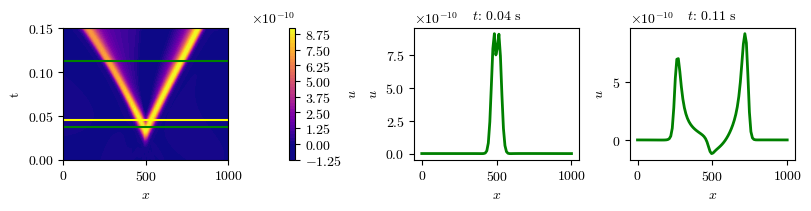

In [22]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(8.0, 2.0))

# Define the fractions for the horizontal lines and line graphs
fractions = [0.25, 0.75]

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, fractions):
    contourf_plot = ax.contourf(x, y, z, origin='lower', extent=(0, 1, 0, 1), levels=50, cmap='plasma', vmax=np.max(u_grid), vmin=np.min(u_grid))
    ax.set_xlabel('$x$')
    ax.set_ylabel('t')
    fig.colorbar(contourf_plot, ax=ax, label='$u$')
    # Draw a horizontal line at t=np.max(t_grid)/2
    ax.axhline(y=np.max(t_grid)*0.3, color='yellow')
    for fraction in fractions:
        ax.axhline(np.max(y)*fraction, color='green')

# Define a function to plot a line graph
def plot_line(ax, x, y, t):
    ax.plot(x, y, color='green', linewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u$')
    ax.set_title("$t$: {:.2f} s".format(t), fontsize=10)

# Plot the contour graph
plot_contour(axs[0], x_grid, t_grid, u_pred, fractions)

# Plot the line graphs
for i, fraction in enumerate(fractions, start=1):
    plot_line(axs[i], x_grid[int(x_grid.shape[0]*fraction),:], u_pred[int(x_grid.shape[0]*fraction),:], t_grid[int(x_grid.shape[0]*fraction),0])


fig.savefig('imgs/4_2_1D_Wave_Source_NNs.png', format='png')
# Display the plot
plt.show()